# Participating to the data challenge: applying, evaluating and submitting a method 

## Fetching the input data

More detail in [](./ocb_dc_ose_2021_data.md)

In [1]:
!dvc get https://github.com/quentinf00/ocb-dc-ose-2021.git datachallenge/data/prepared/input

Cloning ocb-dc-ose-2021.git|                        |0.00/? [00:00,      ?obj/s]

Cloning ocb-dc-ose-2021.git| | Compressing | Compressing objects:   1% (3/248) |

Cloning ocb-dc-ose-2021.git|█████████| Compressing |248/248 [00:00,   2.07obj/s]

  0% Downloading input|                              |0/7 [00:00<?,    ?files/s]
!
datachallenge/data/prepared/input/.gitignore          |0.00 [00:00,        ?B/s]
                                                                                


!
  0%|          |datachallenge/data/prepared/inpu0.00/454k [00:00<?,        ?B/s]



!

  0%|          |datachallenge/data/prepared/inpu0.00/703k [00:00<?,        ?B/s]


!


  0%|          |datachallenge/data/prepared/inp0.00/2.48M [00:00<?,        ?B/s]



!



  0%|          |datachallenge/data/prepared/inp0.00/2.65M [00:00<?,        ?B/s]
 29% Downloading input|███████▏                 |2/7 [00:00<00:00,  8.58files/s]
!
  0%|          |datachallenge/data/prepared/inp0.00/2.39M [00:00<?,        ?B/s]



                                                                                

!

  0%|          |datachallenge/data/prepared/inp0.00/2.22M [00:00<?,        ?B/s]

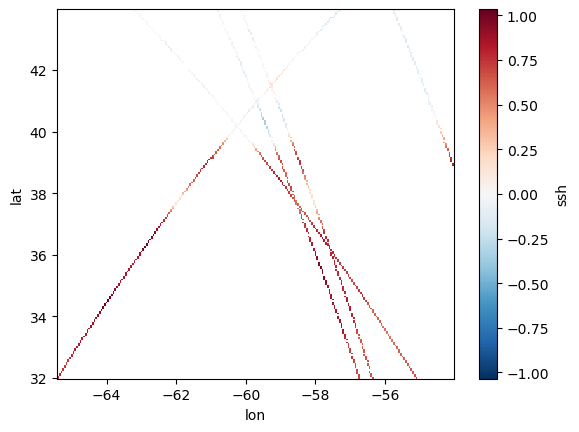

In [2]:
import xarray as xr
obs = xr.open_mfdataset('input/*.nc', combine='nested',concat_dim='time')
bin_size = 1/20
(
    obs.sel(time='2017-01-01').assign(
        lat=obs.lat / bin_size // 1 * bin_size,
        lon=obs.lon / bin_size // 1 * bin_size
    )[['ssh', 'lat', 'lon']].load()
    .drop_vars('time')
    .to_dataframe()
    .groupby(['lat', 'lon']).mean()
    .to_xarray()
).ssh.plot()

### Applying my method: Basic optimal interpolation


![oi shema](imgs/oi_doc.png)

In [3]:
# GIST: https://gist.github.com/quentinf00/2d034392ee9b385fb4de3c8628bfc8cache44
!wget https://gist.githubusercontent.com/quentinf00/2d034392ee9b385fb4de3c8628bfc844/raw/4afecfce184a6e668def7ec3a99cb6cd4d612bdc/patcher_oi_torch.py

--2024-04-10 09:45:57--  https://gist.githubusercontent.com/quentinf00/2d034392ee9b385fb4de3c8628bfc844/raw/4afecfce184a6e668def7ec3a99cb6cd4d612bdc/patcher_oi_torch.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.


HTTP request sent, awaiting response... 

200 OK
Length: 4247 (4,1K) [text/plain]
Saving to: ‘patcher_oi_torch.py’

patcher_oi_torch.py 100%[===================>]   4,15K  --.-KB/s    in 0s      

2024-04-10 09:45:57 (59,0 MB/s) - ‘patcher_oi_torch.py’ saved [4247/4247]



<script src="https://gist.github.com/quentinf00/2d034392ee9b385fb4de3c8628bfc844.js"></script>

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
from functools import partial
from xrpatcher import XRDAPatcher
from patcher_oi_torch import oi


outgrid = oi(
        outgrid_da=xr.DataArray(
            dims=('time', 'lat', 'lon'),
            coords=dict(
                time=pd.date_range("2017-01-01", "2017-12-31"),
                lat=np.arange(33, 43, 0.25),
                lon=np.arange(-65, -55, 0.25),
            ),
        ),
        patcher_cls=partial(XRDAPatcher,
            patches=dict(time=5, lat=40, lon=40),
            strides=dict(time=5, lat=40, lon=40)
        ),
        obs=obs.load(),
        lt=pd.to_timedelta('7D'), lx=1., ly=1.,
        noise=0.05,
        obs_dt=pd.to_timedelta('1D'), obs_dx=0.25, obs_dy=0.25,
        device='cuda'
    )

  0%|                                                                                                                                                                                         | 0/73 [00:00<?, ?it/s]

  1%|██▍                                                                                                                                                                              | 1/73 [00:03<03:59,  3.33s/it]

  3%|████▊                                                                                                                                                                            | 2/73 [00:03<01:51,  1.56s/it]

  4%|███████▎                                                                                                                                                                         | 3/73 [00:03<01:09,  1.01it/s]

  5%|█████████▋                                                                                                                                                                       | 4/73 [00:04<00:49,  1.39it/s]

  7%|████████████                                                                                                                                                                     | 5/73 [00:04<00:38,  1.75it/s]

  8%|██████████████▌                                                                                                                                                                  | 6/73 [00:04<00:32,  2.07it/s]

 10%|████████████████▉                                                                                                                                                                | 7/73 [00:05<00:27,  2.36it/s]

 11%|███████████████████▍                                                                                                                                                             | 8/73 [00:05<00:25,  2.59it/s]

 12%|█████████████████████▊                                                                                                                                                           | 9/73 [00:05<00:23,  2.76it/s]

 14%|████████████████████████                                                                                                                                                        | 10/73 [00:06<00:21,  2.89it/s]

 15%|██████████████████████████▌                                                                                                                                                     | 11/73 [00:06<00:20,  2.99it/s]

 16%|████████████████████████████▉                                                                                                                                                   | 12/73 [00:06<00:19,  3.07it/s]

 18%|███████████████████████████████▎                                                                                                                                                | 13/73 [00:07<00:19,  3.12it/s]

 19%|█████████████████████████████████▊                                                                                                                                              | 14/73 [00:07<00:17,  3.29it/s]

 21%|████████████████████████████████████▏                                                                                                                                           | 15/73 [00:07<00:16,  3.47it/s]

 22%|██████████████████████████████████████▌                                                                                                                                         | 16/73 [00:07<00:15,  3.70it/s]

 23%|████████████████████████████████████████▉                                                                                                                                       | 17/73 [00:07<00:13,  4.01it/s]

 25%|███████████████████████████████████████████▍                                                                                                                                    | 18/73 [00:08<00:12,  4.30it/s]

 26%|█████████████████████████████████████████████▊                                                                                                                                  | 19/73 [00:08<00:11,  4.56it/s]

 27%|████████████████████████████████████████████████▏                                                                                                                               | 20/73 [00:08<00:11,  4.75it/s]

 29%|██████████████████████████████████████████████████▋                                                                                                                             | 21/73 [00:08<00:10,  4.89it/s]

 30%|█████████████████████████████████████████████████████                                                                                                                           | 22/73 [00:08<00:10,  4.93it/s]

 32%|███████████████████████████████████████████████████████▍                                                                                                                        | 23/73 [00:09<00:10,  4.93it/s]

 33%|█████████████████████████████████████████████████████████▊                                                                                                                      | 24/73 [00:09<00:09,  4.91it/s]

 34%|████████████████████████████████████████████████████████████▎                                                                                                                   | 25/73 [00:09<00:09,  4.91it/s]

 36%|██████████████████████████████████████████████████████████████▋                                                                                                                 | 26/73 [00:09<00:09,  4.90it/s]

 37%|█████████████████████████████████████████████████████████████████                                                                                                               | 27/73 [00:09<00:09,  4.85it/s]

 38%|███████████████████████████████████████████████████████████████████▌                                                                                                            | 28/73 [00:10<00:09,  4.80it/s]

 40%|█████████████████████████████████████████████████████████████████████▉                                                                                                          | 29/73 [00:10<00:09,  4.78it/s]

 41%|████████████████████████████████████████████████████████████████████████▎                                                                                                       | 30/73 [00:10<00:09,  4.76it/s]

 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                     | 31/73 [00:10<00:08,  4.79it/s]

 44%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 32/73 [00:11<00:08,  4.75it/s]

 45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                | 33/73 [00:11<00:08,  4.74it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 34/73 [00:11<00:08,  4.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 35/73 [00:11<00:07,  4.79it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 36/73 [00:11<00:07,  4.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 37/73 [00:12<00:07,  4.53it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 38/73 [00:12<00:08,  4.35it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 39/73 [00:12<00:08,  4.12it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 40/73 [00:12<00:08,  3.81it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 41/73 [00:13<00:08,  3.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 42/73 [00:13<00:09,  3.37it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 43/73 [00:13<00:09,  3.32it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 44/73 [00:14<00:08,  3.27it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 45/73 [00:14<00:08,  3.23it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 46/73 [00:14<00:08,  3.21it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 47/73 [00:15<00:08,  3.19it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 48/73 [00:15<00:07,  3.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 49/73 [00:15<00:07,  3.20it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 50/73 [00:16<00:07,  3.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 51/73 [00:16<00:06,  3.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 52/73 [00:16<00:06,  3.48it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 53/73 [00:16<00:05,  3.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 54/73 [00:17<00:04,  3.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 55/73 [00:17<00:04,  4.07it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 56/73 [00:17<00:03,  4.25it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 57/73 [00:17<00:03,  4.35it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 58/73 [00:17<00:03,  4.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 59/73 [00:18<00:03,  4.52it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 60/73 [00:18<00:02,  4.59it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 61/73 [00:18<00:02,  4.63it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62/73 [00:18<00:02,  4.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 63/73 [00:19<00:02,  4.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 64/73 [00:19<00:01,  4.78it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 65/73 [00:19<00:01,  4.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 66/73 [00:19<00:01,  4.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 67/73 [00:19<00:01,  4.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 68/73 [00:20<00:01,  4.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 69/73 [00:20<00:00,  4.85it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 70/73 [00:20<00:00,  4.84it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 71/73 [00:20<00:00,  4.79it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 72/73 [00:20<00:00,  4.84it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:21<00:00,  4.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:21<00:00,  3.46it/s]

### Visualize results

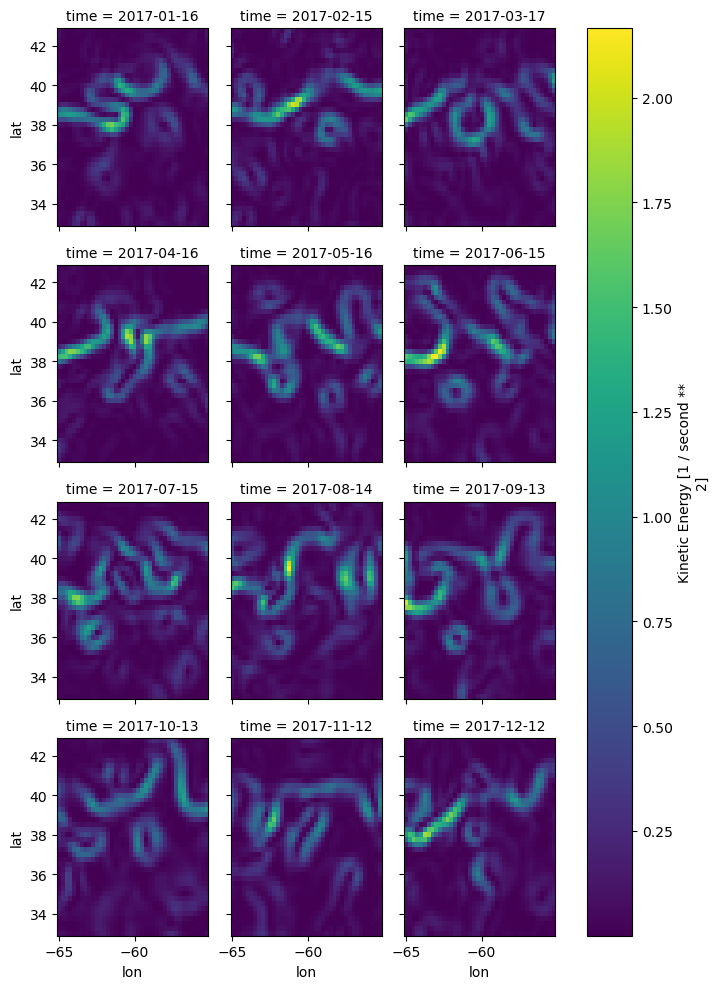

In [5]:
import ocn_tools._src.geoprocessing.geostrophic as geo
(
    outgrid.to_dataset(name='ssh')
    .pipe(geo.geostrophic_velocities)
    .pipe(geo.kinetic_energy)
    .isel(time=slice(15, None, 30)
).ke.plot(col='time', col_wrap=3, figsize=(7,10))
)

## Evaluate

### Fetch reference data

In [6]:
%%bash
dvc get  https://github.com/quentinf00/ocb-dc-ose-2021.git \
  datachallenge/data/prepared/ref \
  -o data/prepared/ref

### Use the configured `ocb-dc_ose_2021-metrics`

In [7]:
outgrid.to_dataset(name='ssh').to_netcdf('output.nc')

In [8]:
%%bash
ocb-dc_ose_2021-metrics params.study_path=output.nc \
    'to_run=[_03_interp_on_track,_04_1_lambdax,_04_2_mu]'

[2024-04-10 09:46:26,197][aprl.appareil][INFO] - Starting


[2024-04-10 09:46:26,197][aprl.appareil][INFO] - Running part _03_interp_on_track


[2024-04-10 09:46:26,198][ocb_dc_ose_2021.mods.interp_on_track][INFO] - Starting


[2024-04-10 09:46:27,134][ocb_dc_ose_2021.mods.interp_on_track][INFO] - Done


[2024-04-10 09:46:27,135][aprl.appareil][INFO] - part _03_interp_on_track done


[2024-04-10 09:46:27,135][aprl.appareil][INFO] - Running part _04_1_lambdax


[2024-04-10 09:46:27,135][ocb_dc_ose_2021.mods.lambdax][INFO] - Starting


[2024-04-10 09:46:27,212][ocb_dc_ose_2021.mods.lambdax][INFO] - Effective scale resolved (interpolated at score 0.5) 143.37


[2024-04-10 09:46:27,222][ocb_dc_ose_2021.mods.lambdax][INFO] - Done


[2024-04-10 09:46:27,223][aprl.appareil][INFO] - part _04_1_lambdax done


[2024-04-10 09:46:27,223][aprl.appareil][INFO] - Running part _04_2_mu


[2024-04-10 09:46:27,223][ocb_dc_ose_2021.mods.mu][INFO] - Starting


[2024-04-10 09:46:27,260][ocb_dc_ose_2021.mods.mu][INFO] - Mu score: 0.8818722045815395


[2024-04-10 09:46:27,261][ocb_dc_ose_2021.mods.mu][INFO] - Done


[2024-04-10 09:46:27,261][aprl.appareil][INFO] - part _04_2_mu done


[2024-04-10 09:46:27,261][aprl.appareil][INFO] - Done


In [9]:
import pandas as pd
import glob
print(pd.concat([pd.read_json(p, typ='series') for p in glob.glob('data/metrics/*.json')]).to_markdown())

|             |          0 |
|:------------|-----------:|
| $\mu$       |   0.881872 |
| $\lambda_x$ | 143.366    |


## Submit method to datachallenge

### Make your reconstruction public through a http link
```bash
aws s3 cp output.nc s3://melody/quentin_cloud/ocb_oi_demo.nc --acl public-read
```

### Push a branch `leaderboard/<>` adding your method
```bash
git clone https://$GTOKEN@github.com/quentinf00/ocb-dc-ose-2021.git
cd ocb-dc-ose-2021
git checkout -b leaderboard/submit-oi-demo

echo '' >> datachallenge/methods.toml
echo '[methods.oi_demo]' >> datachallenge/methods.toml
echo 'url = "https://s3.eu-west-2.wasabisys.com/melody/quentin_cloud/ocb_oi_demo.nc"' >> datachallenge/methods.toml
echo 'var = "ssh"' >> datachallenge/methods.toml

git add .
git commit -m "Demo OI Submission"
git push origin leaderboard/submit-oi-demo -f

!cat "Pull request here: https://github.com/quentinf00/ocb-dc-ose-2021/compare/leaderboard/submit-oi-demo?expand=1"
```

<iframe src=https://github.com/quentinf00/ocb-dc-ose-2021/pull/4/commits/af4c6084cb93089742fe0b563877f8996e2afc08#diff-62cd5b9a69ab1e4203f56d494c890b0b301b8c5eee9bd59e3a87ea36e2a3b3ec></iframe>

### Leaderboard is automatically updated